# Empirical Asset Pricing A 2021
## Homework 1: on classical puzzles of finance
**Xinyu Liu, INSEAD**

**10.01.2021**

## Overview

The goal of this exercise is to establish the basic intuition of notions such as excess market return, risk free rate, consumption growth and inflation. Based on that we can explore the stylized fact of SDF, and eventually test a simple CRRA lognormal model against these facts, by looking at the size of relative risk aversion, etc.

## Preparation: Import packages and access data


In [1]:
import pandas_datareader.data as web  # module for reading datasets directly from the web
#pip install pandas-datareader (in case you haven't install this package)
from pandas_datareader.famafrench import get_available_datasets
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import datapungibea as dpb

In [2]:
###########################
# Fama French Data Grabber
###########################
#https://randlow.github.io/posts/finance-economics/pandas-datareader-KF/
#Please refer to this link if you have any further questions.

#You can extract all the available datasets from Ken French's website and find that there are 297 of them. We can opt to see all the datasets available.
datasets = get_available_datasets()
print('No. of datasets:{}'.format(len(datasets)))
#datasets # comment out if you want to see all the datasets

No. of datasets:297


In [3]:
###########################
#Customize your data selection
###########################
#Note:If this is what you are intended to find: '6_Portfolios_ME_OP_2x3', but don't know exactly what it is named, do the following line
#df_me_op_factor = [dataset for dataset in datasets if 'ME' in dataset and 'OP' in dataset and '2x3' in dataset]
#print(df_me_op_factor)

#It is important to check the description of the dataset we access by using the following codes 
Datatoread='F-F_Research_Data_Factors'
sdate='1948-01-01'
edate='2017-12-31'
ds_factors = web.DataReader(Datatoread,'famafrench',start=sdate,end=edate) # Taking [0] as extracting 1F-F-Research_Data_Factors_2x3')
print('\nKEYS\n{}'.format(ds_factors.keys()))
print('DATASET DESCRIPTION \n {}'.format(ds_factors['DESCR']))
#From the printed information we know that we need to select the "0" name in the dictionary
#copy the right dict for later examination
dfFactor = ds_factors[1].copy()
dfFactor.reset_index(inplace=True)
# I check the scale of the data by printing out the head:
dfFactor.head()


KEYS
dict_keys([0, 1, 'DESCR'])
DATASET DESCRIPTION 
 F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202011 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2020 Kenneth R. French

  0 : (840 rows x 4 cols)
  1 : Annual Factors: January-December (70 rows x 4 cols)


,Date,Mkt-RF,SMB,HML,RF
0,1948,1.07,-9.14,3.52,0.81
1,1949,19.12,3.93,-4.55,1.10
2,1950,28.82,0.93,27.01,1.20
3,1951,19.22,-4.93,-5.93,1.49
4,1952,11.80,-6.66,3.34,1.66


In [4]:
#Date format adjustment
dfFactor['Date']=dfFactor['Date'].dt.year
dfFactor = dfFactor.set_index(['Date'])
# dfFactor['Date']=dfFactor['Date'].dt.to_timestamp(freq='M').dt.strftime('%Y-%m')
#Obtained object dtype
# dfFactor.index=pd.to_datetime(dfFactor.index)
#Obtained dt64, which is needed for the plotting 

In [5]:
###########################
# Consumption & Inflation Data Grabber
###########################
# https://pypi.org/project/datapungibea/
# Connect to Bureau of Economic Analysis (BEA) API
BEA_data = dpb.data('FDA2D756-CC0A-4AAA-A1D5-980FA23F31BB') #or data = dpb.data("API Key")
NIPA_cons=BEA_data.NIPA('T20302')
#Download annual consumption data on nondurable goods from Table 2.3.2. 
#on “Contributions to Percent Change in Real Personal Consumption Expenditures by Major Type of Product”
NIPA_cons.reset_index(inplace=True)
Consumption_data=NIPA_cons[NIPA_cons['LineDescription']=='-Nondurable goods']
Consumption_data = Consumption_data.T.iloc[4:,:]
Consumption_data.columns=['Consumption']

NIPA_inflation=BEA_data.NIPA('T10107')
NIPA_inflation.reset_index(inplace=True)
Inflation_data=NIPA_inflation[NIPA_inflation['LineDescription']=='--Nondurable goods']
Inflation_data = Inflation_data.T.iloc[4:,:]
Inflation_data.columns=['Inflation']

NIPA_data = pd.merge(Consumption_data,Inflation_data, how='inner', left_index= True, right_index=True)
NIPA_data=NIPA_data.astype(float)
NIPA_data.index=pd.to_datetime(NIPA_data.index)
NIPA_data=NIPA_data.resample('Y').mean()
year = NIPA_data.reset_index()['index'].dt.year
NIPA_data.loc[:,'Date']=year.values
NIPA_data = NIPA_data[(NIPA_data['Date']>=1948) & (NIPA_data['Date']<=2017)]
NIPA_data = NIPA_data.set_index('Date')

In [9]:
# Merge the data 
merged_data = dfFactor.merge(NIPA_data,how='left', left_index=True,right_index=True)
merged_data = merged_data.reset_index()
merged_data['Date'] = pd.to_datetime(merged_data['Date'],format='%Y')
merged_data = merged_data.set_index('Date')
merged_data['Mkt'] = merged_data['Mkt-RF'] + merged_data['RF'] 
merged_data['RF_adj'] = merged_data['RF'] - merged_data['Inflation'] 
# Drop irrelavent columns
merged_data_plot = merged_data.drop(columns=['SMB','HML','RF','Mkt'])

## Analysis

C:\Users\WENTWORTHLIU\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


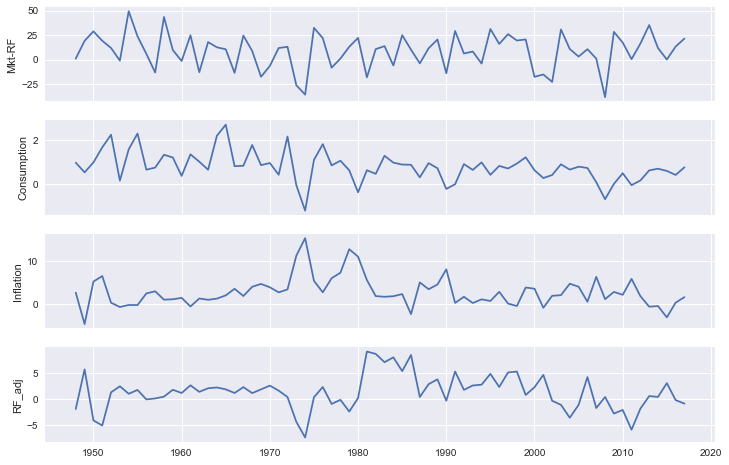

In [7]:
###########################
#Plot out the graphs
###########################
#See this link for detailed guidance on date ticks
# https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/date.html
# I am troubled by adjusting the format and making subplots for the whole evening and it turns out that things can be simplified in the following way:
years_fmt = mdates.DateFormatter('%Y')
#This will be used as input to adjust the axis label to be in the unit of year
n = len(merged_data_plot.columns)
fig, axes = plt.subplots(n,1,figsize=(12,8),sharex=True)
#Using sharex help making the plot simple and easy to read
# Create fig and axes class so I can then process with them in the for loop.
# fig.suptitle('Time series of relevant variables',fontsize=16)
for k,factortitle in enumerate(merged_data_plot.columns):
    ax = axes[k]
    ax.plot(merged_data_plot.index,merged_data_plot[[factortitle]])
    ax.xaxis.set_major_formatter(years_fmt)
    ax.set_ylabel(factortitle)
plt.savefig("Time series")
plt.show()

In [10]:
#I take log transformation of the returns to fit the setting of theory
merged_data = np.log(merged_data/100+1)*100
#Calculate summary statistics 
summary_stats = pd.DataFrame()
summary_stats.loc[0,'average market excess return'] = merged_data['Mkt-RF'].mean()*0.01
summary_stats.loc[0,'average risk-free rate'] = (merged_data['RF'].mean()-merged_data['Inflation'].mean())*0.01
summary_stats.loc[0,'volatility of market return'] = merged_data['Mkt'].std()*0.01
summary_stats.loc[0,'volatility of market excess return'] = merged_data['Mkt-RF'].std()*0.01
summary_stats.loc[0,'volatility of consumption growth'] = Consumption_data['Consumption'].std()*0.01
summary_stats.loc[0,'covariance of market and consumption'] = merged_data[['Consumption','Mkt']].cov().iloc[0,1]*0.0001

#Make latex table
print(summary_stats.to_latex(index=False))

\begin{tabular}{rrrrrr}
\toprule
 average market excess return &  average risk-free rate &  volatility of market return &  volatility of market excess return &  volatility of consumption growth &  covariance of market and consumption \\
\midrule
                     0.067613 &                0.013193 &                      0.16423 &                            0.176063 &                           0.01191 &                              0.000462 \\
\bottomrule
\end{tabular}



In [13]:
# Define a funtion to calculate the risk aversion coefficient
def risk_aversion_etd(Er_Mkt, rf, vol_mkt, vol_cons, rho):
    gamma = (Er_Mkt - rf + vol_mkt**2/2)/(vol_cons* vol_mkt* rho)
    return gamma 
merged_data[['Consumption','Mkt']].corr().iloc[0,1]
x_rho = np.linspace(0.15,1, 100)
y_rra = risk_aversion_etd(summary_stats.loc[0,'average market excess return'],summary_stats.loc[0,'average risk-free rate'],summary_stats.loc[0,'volatility of market excess return'],summary_stats.loc[0,'volatility of consumption growth'],x_rho)

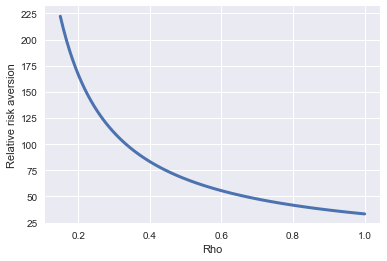

In [14]:
# Make the plot of RRA(rho)
plt.plot(x_rho, y_rra,linewidth=3)
plt.xlabel('Rho')
plt.ylabel('Relative risk aversion')
plt.savefig("p3q1")

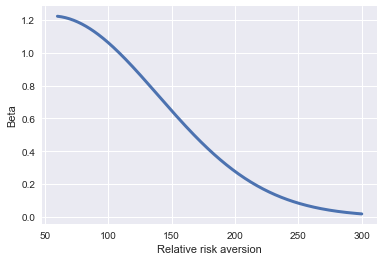

In [154]:
# Define a funtion to calculate the subjective discount factor
def beta_cal(rf, gamma, ave_c, vol_c):
    beta = np.exp(-rf+gamma*ave_c-gamma**2*vol_c**2/2)
    return beta
rf = merged_data['RF_adj'].mean()*0.01
ave_c = Consumption_data['Consumption'].mean()*0.01
vol_c = Consumption_data['Consumption'].std()*0.01
# Make the plot of gamma(RRA)
x_gamma= np.linspace(60,300, 300)
y_Beta = beta_cal(rf, x_gamma, ave_c, vol_c)
plt.plot(x_gamma, y_Beta,linewidth=3)
plt.xlabel('Relative risk aversion')
plt.ylabel('Beta')
plt.savefig("p3q2")
